
# Clustering Human Activity using Inertial Sensors Data


## Note:
* Use the next cell to download the data directly, if that didn't work. you can download it manually (available at [UCI archive](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)) a copy will also be available on Piazza.

* Don't change the part of the code that labels `#Do not change`

* Attach this notebook to your answer sheet with all outputs visible.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import os
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


In [ ]:

#### Download the dataset
import urllib.request
import zipfile

dataset_url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
zip_file_path = "Dataset.zip"
extracted_downloaded_folder = "Dataset"
extracted_data_folder = "UCI HAR Dataset"

if not os.path.exists(zip_file_path):
    print("Downloading the dataset...")
    urllib.request.urlretrieve(dataset_url, zip_file_path)

if not os.path.exists(extracted_downloaded_folder):
    print("Extracting the dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

if not os.path.exists(extracted_data_folder):
    print("Extracting the dataset...")
    with zipfile.ZipFile(extracted_data_folder +'.zip', 'r') as zip_ref:
        zip_ref.extractall(".")

print("Dataset is ready.")


Extracting the dataset...
Extracting the dataset...
Dataset is ready.


### Load the data into a dataframe


In [ ]:

# Define paths to data files

train_path = "UCI HAR Dataset/train/"
test_path = "UCI HAR Dataset/test/"
activity_mapper_path = "UCI HAR Dataset/activity_labels.txt"



# Function to load and preprocess data
def load_data(data_path):
    X = pd.read_csv(f"{data_path}X_{data_path.split('/')[-2]}.txt", header=None, sep='\s+')
    y = pd.read_csv(f"{data_path}y_{data_path.split('/')[-2]}.txt", header=None, names=['Activity'])
    return X, y

# Load training and testing data
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# First scale the featruses (kmeans requires s)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform, not fit_transform, on test data

# Convert back to DataFrame with original column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Add 'Activity' column to training_df and testing_df
training_df = pd.concat([X_train, y_train], axis=1)
testing_df = pd.concat([X_test, y_test], axis=1)


print("First 5 rows of training feature dataframe:")
training_df.head()


First 5 rows of training feature dataframe:


0         1         2         3         4         5         6  \
0  0.200642 -0.063683 -0.419628 -0.868814 -0.939441 -0.737529 -0.859817   
1  0.055948  0.031486 -0.253908 -0.875426 -0.923902 -0.849304 -0.868531   
2  0.073515 -0.043416 -0.076295 -0.869039 -0.907760 -0.893785 -0.863137   
3  0.066696 -0.208422 -0.249712 -0.870626 -0.940022 -0.921805 -0.864503   
4  0.030469  0.027587 -0.109848 -0.875188 -0.934878 -0.921343 -0.867384   

          7         8         9  ...       552       553       554       555  \
0 -0.939019 -0.766437 -0.856036  ...  0.025960 -0.276399 -0.360603  0.062940   
1 -0.921998 -0.848928 -0.871359  ... -0.897357 -0.767990  0.133011 -0.021461   
2 -0.898854 -0.896701 -0.863323  ... -0.260878 -0.438316 -0.377840  0.391976   
3 -0.938124 -0.925279 -0.863323  ...  0.591045  0.463155 -0.135025 -0.033637   
4 -0.931789 -0.928028 -0.870260  ... -0.138515 -0.240313  0.340406  0.268486   

        556       557       558       559       560  Activity  
0 -0.778427 -0.026080 -0.687219  0.407946 -0.007568         5  
1 -1.218805  1.484470 -0.694138  0.409117  0.007875         5  
2  0.151207  1.704201 -0.702239  0.410288  0.026502         5  
3  1.037851 -1.003019 -0.701684  0.414650  0.031714         5  
4  1.125918 -1.276282 -0.700152  0.425463  0.045225         5  

[5 rows x 562 columns]

#### Visualize the data

In [ ]:


# 2. Use the featre decoder to create Acitivtiy Name column

# Load activity labels
activity_labels = pd.read_csv(activity_mapper_path, header=None, sep='\s+', names=['id', 'activity_name'])

# Create mapping dictionary {1: "WALKING", 2: "WALKING_UPSTAIRS", ...}
activity_mapping = dict(zip(activity_labels['id'], activity_labels['activity_name']))

Activity_Name = training_df['Activity'].map(activity_mapping)

# 3. Visualize training data using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Create a scatter plot
plt.figure(figsize=(8, 6))
activities = Activity_Name.unique()
colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Assign colors to activities

for i, activity in enumerate(activities):
    plt.scatter(X_train_pca[Activity_Name == activity, 0],
                X_train_pca[Activity_Name == activity, 1],
                c=colors[i], label=activity)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()



## Kmeans Clustering and The Optimal Number of Clusters

#### 1.  **Elbow Method**

In [ ]:

# 1. Elbow Method
inertia_values = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)


In [ ]:

# Plotting the Elbow Method
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 16), inertia_values, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.xticks(range(2, 16))
plt.grid(True)
plt.show()




# Choose k based on the elbow method
elbow_k = 3 # Change this based on the plot
kmeans_elbow = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
clusters_elbow = kmeans_elbow.fit_predict(X_train)

# PCA for visualization
pca = PCA(n_components=2)
X_train_pca_elbow = pca.fit_transform(X_train)

# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(elbow_k):
    plt.scatter(X_train_pca_elbow[clusters_elbow == i, 0], X_train_pca_elbow[clusters_elbow == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clustering with k={elbow_k} (Elbow Method)')
plt.legend()
plt.grid(True)
plt.show()




#### 2.  Adjusted Rand Index (ARI)

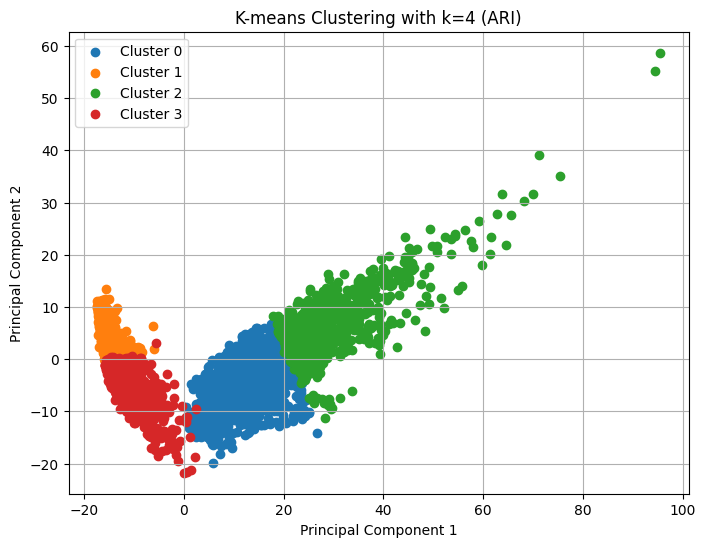

In [ ]:

# 2. Adjusted Rand Index (ARI)
ari_scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_train)
    ari = adjusted_rand_score(y_train.squeeze(), clusters)
    ari_scores.append(ari)

# Plotting ARI Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 16), ari_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Adjusted Rand Index (ARI) for Optimal k')
plt.xticks(range(2, 16))
plt.grid(True)
plt.show()

# Choose k based on ARI
ari_k = 4 # Change this based on the plot
kmeans_ari = KMeans(n_clusters=ari_k, random_state=42, n_init=10)
clusters_ari = kmeans_ari.fit_predict(X_train)

# PCA for visualization
pca = PCA(n_components=2)
X_train_pca_ari = pca.fit_transform(X_train)
# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(ari_k):
    plt.scatter(X_train_pca_ari[clusters_ari == i, 0], X_train_pca_ari[clusters_ari == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clustering with k={ari_k} (ARI)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
clusters.shape

(7352,)

## Prototype Selection using K-means Clustering.

### 1. Random Selection

In [ ]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def random_prototype_selection(X, y, n_samples):
    """
    Selects a random subset from the data. train a logistic regression model
    on the selected data.

    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target labels.
        n_samples(int): The number of samples to select from each class.

    Returns:
        tuple: A tuple containing the selected features (X_selected) and labels (y_selected).
    """
    indices = np.random.choice(X.index, n_samples, replace=False)
    X_selected = X.loc[indices]
    y_selected = y.loc[indices]
    return X_selected, y_selected

# Assuming X_train and y_train are defined from the previous code
n_repetitions = 10
accuracies = []
n_samples = 120

for _ in range(n_repetitions):
    X_train_selected_random, y_train_selected_random = random_prototype_selection(X_train, y_train, n_samples)
    logistic_regression_random = LogisticRegression(random_state=42, max_iter=1000)
    logistic_regression_random.fit(X_train_selected_random, y_train_selected_random.values.ravel())
    y_pred_random = logistic_regression_random.predict(X_test)
    accuracy_random = accuracy_score(y_test, y_pred_random)
    accuracies.append(accuracy_random)

average_accuracy = np.mean(accuracies)
print(f"Average Accuracy with Random Selection over {n_repetitions} repetitions: {average_accuracy:.4f}")


Average Accuracy with Random Selection over 10 repetitions: 0.8457


### 2. K-means Clustering by Class


In [ ]:

# 2. K-means Clustering by Class
def kmeans_prototype_selection(X, y, n_prototypes_per_class):
    """
    Selects prototypes using K-means clustering for each class.

    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target labels.
        n_prototypes_per_class (int): The number of prototypes to select from each class.

    Returns:
        pd.DataFrame: The selected prototypes.
        pd.Series: The selected labels.
    """
    X_selected = []
    y_selected = []
    for class_label in y.unique():
        X_class = X[y == class_label]
        y_class = y[y == class_label]
        if len(X_class) > n_prototypes_per_class:

            kmeans = KMeans(n_clusters=n_prototypes_per_class, random_state=42, n_init=10)
            kmeans.fit(X_class)
            centroids = kmeans.cluster_centers_
            # Find the closest points to the centroids
            closest_points_indices = []
            for centroid in centroids:
                distances = np.linalg.norm(X_class.values - centroid, axis=1)
                closest_index = np.argmin(distances)
                closest_points_indices.append(X_class.iloc[[closest_index]].index[0])
            X_selected.append(X_class.loc[closest_points_indices])
            y_selected.append(y_class.loc[closest_points_indices])
        else:
            X_selected.append(X_class)
            y_selected.append(y_class)
    X_selected = pd.concat(X_selected)
    y_selected = pd.concat(y_selected)
    return X_selected, y_selected

# Select prototypes using K-means
X_train_selected_kmeans, y_train_selected_kmeans = kmeans_prototype_selection(X_train, y_train['Activity'], 20)

# Train Logistic Regression model
logistic_regression_kmeans = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression_kmeans.fit(X_train_selected_kmeans, y_train_selected_kmeans)

# Make predictions and calculate accuracy
y_pred_kmeans = logistic_regression_kmeans.predict(X_test)
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
print(f"Accuracy with K-means Selection: {accuracy_kmeans:.4f}")





Accuracy with K-means Selection: 0.9006


In [ ]:
X_train_selected_kmeans

0         1         2         3         4         5         6    \
3640 -0.034931 -0.222790 -0.149982 -0.871154 -0.941288 -0.895586 -0.863072   
3250 -0.036207 -0.081557 -0.105639 -0.871257 -0.932374 -0.915849 -0.863025   
3817  0.028529  0.245592  0.234413 -0.825891 -0.592642 -0.635728 -0.819789   
5511  0.025172  0.038772  0.086413 -0.873672 -0.940289 -0.922209 -0.865939   
2879  0.048571 -0.005527 -0.103521 -0.875172 -0.945719 -0.916835 -0.867165   
...        ...       ...       ...       ...       ...       ...       ...   
6795 -0.087133  0.402593  0.111642  0.925182  0.695420  1.647835  0.768519   
986  -1.656603 -0.558189 -0.452209  1.491361  1.544858  0.728870  1.403606   
3028  0.204280 -0.145556 -0.071355  0.546625  0.925284  0.976508  0.498208   
1895 -0.225589 -1.475641  0.501807  0.701885  2.087120  2.193579  0.616934   
4173 -1.312908  0.344391 -0.154987  0.953216  1.524903  0.960993  1.011079   

           7         8         9    ...       551       552       553  \
3640 -0.941298 -0.904057 -0.875820  ...  0.738975 -0.785796 -0.769080   
3250 -0.927432 -0.919902 -0.871964  ...  1.208665 -0.941148 -0.944087   
3817 -0.575541 -0.621776 -0.832654  ... -1.908123  0.417241  0.106014   
5511 -0.938069 -0.927776 -0.871427  ...  1.240147 -0.356849 -0.281751   
2879 -0.943728 -0.921772 -0.869465  ... -0.489928 -0.667266 -0.760251   
...        ...       ...       ...  ...       ...       ...       ...   
6795  0.793958  1.772706  1.361703  ... -0.332678 -0.512663 -0.638589   
986   1.627394  0.736209  1.622530  ... -1.128892 -0.229736 -0.408478   
3028  0.988468  0.899767  0.666324  ...  0.106371  0.988938  0.793912   
1895  1.994702  2.057245  0.882903  ...  0.177702 -0.231142 -0.375462   
4173  1.440889  0.948053  0.896752  ...  0.111538 -0.212458 -0.124019   

           554       555       556       557       558       559       560  
3640  0.052952 -0.368535  1.077953  1.417016 -0.434649  0.732310 -0.057158  
3250  0.062951 -0.228935 -0.353532 -0.305443 -0.342910  0.540733  0.996292  
3817  0.109098  0.239540  1.269208 -1.388769 -0.548005  0.517280 -0.143887  
5511  0.318298  0.177918  0.460838 -0.488542 -0.739867  0.403428  0.105690  
2879 -0.433183  0.712576  0.047131 -1.612996 -0.534174  0.518744  0.700653  
...        ...       ...       ...       ...       ...       ...       ...  
6795  0.762188 -1.525036 -0.309875  1.866410 -0.580173  0.607398  0.106768  
986   1.457952 -1.393800 -1.524664  1.133779 -0.455241  0.771525  0.361256  
3028 -1.822664  0.850425 -1.626751 -0.226384 -0.001637  0.782410  1.335105  
1895 -0.068888  0.891182 -1.367372 -0.637108 -0.070742  0.724369  1.275441  
4173  2.059711  1.693309 -1.258539  1.197907  0.089095  1.136863  1.110176  

[120 rows x 561 columns]

## Autoencoder for Features Learning.


####1.  Data Preparation:

In [ ]:
import glob
# Load data with proper tensor formatting
def load_inertial_data(path):
    files = glob.glob(path)
    data_dict = {}
    for f in files:
        name = f.split('/')[-1][:-4]
        # Read as numpy array and convert to float32
        data_dict[name] = pd.read_csv(f, sep='\s+', header=None).values.astype(np.float32)
    return data_dict

# Load training data
train_data = load_inertial_data("/content/UCI HAR Dataset/train/Inertial Signals/*.txt")
train_labels = pd.read_csv("/content/UCI HAR Dataset/train/y_train.txt", header=None)[0].values


In [ ]:
['body_acc_y_train', 'total_acc_y_train', 'total_acc_x_train', 'body_gyro_z_train', 'body_acc_x_train', 'body_acc_z_train', 'body_gyro_y_train', 'total_acc_z_train', 'body_gyro_x_train']

In [ ]:
print(f"{train_data.keys()}")

dict_keys(['body_acc_y_train', 'total_acc_y_train', 'total_acc_x_train', 'body_gyro_z_train', 'body_acc_x_train', 'body_acc_z_train', 'body_gyro_y_train', 'total_acc_z_train', 'body_gyro_x_train'])


In [ ]:
train_data['body_acc_x_train'].shape

(7352, 128)

In [ ]:
# Create PyTorch Dataset
class SensorsDataset(Dataset):
    def __init__(self, data_dict, labels):
        # Stack all signals along the feature dimension
        self.data = torch.stack([
            torch.tensor(data_dict[key]) for key in data_dict.keys()
        ], dim=2)  # Shape: (num_samples, 128, num_features)

        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create dataset and dataloader
train_dataset = SensorsDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Verify shapes
sample, label = next(iter(train_loader))
print(f"Input shape: {sample.shape}")  # Should be (batch_size, 128, 9)
print(f"Label shape: {label.shape}")   # Should be (batch_size)


Input shape: torch.Size([32, 128, 9])
Label shape: torch.Size([32])



#### 2. Autoencoder Implementation

In [ ]:

# 2. Autoencoder Implementation
class TimeSeriesAE(nn.Module):
    def __init__(self, input_size=9, encoding_dim=64):
        super().__init__()
        # Encoder
        self.encoder = torch.nn.GRU(
            input_size=input_size,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.enc_fc = torch.nn.Linear(128, encoding_dim)  # 64*2 for bidirectional

        # Decoder
        self.dec_fc = torch.nn.Linear(encoding_dim, 64)
        self.decoder = torch.nn.GRU(
            input_size=64,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.output_layer = torch.nn.Linear(128, input_size)

    def forward(self, x):
        # Encoding
        _, hidden = self.encoder(x)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)  # Combine bidirectional
        encoded = self.enc_fc(hidden)

        # Decoding
        decoded = self.dec_fc(encoded).unsqueeze(1).repeat(1, x.size(1), 1)
        out, _ = self.decoder(decoded)
        reconstructed = self.output_layer(out)

        return reconstructed, encoded



# Instantiate the model
input_size = 9  # Number of features
hidden_size = 64
latent_size = 32
model = TimeSeriesAE(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, _ in train_loader:
        optimizer.zero_grad()
        reconstructed_X, _ = model(batch_X)
        loss = criterion(reconstructed_X, batch_X)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")



KeyboardInterrupt: 

In [ ]:
# 3. Embedding Extraction and Visualization


ae_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Extract embeddings for the training data
model.eval()
embeddings = []
train_labels = []
with torch.no_grad():
    for batch_X ,_ in ae_loader:
        _, z = model(batch_X)
        embeddings.append(z.numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Create a scatter plot of the 2D embeddings
plt.figure(figsize=(8, 6))
activities = np.unique(y_train)
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_train.values, cmap='viridis', alpha=0.6)
plt.colorbar(label='Activity Class')
plt.title('Autoencoder Embeddings')
plt.show()


In [ ]:
## Optional ploting the PCA of the embeddings.
# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a scatter plot of the 2D embeddings
plt.figure(figsize=(8, 6))
activities = np.unique(y_train.values)
colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Assign colors to activities

for i, activity in enumerate(activities):
    plt.scatter(embeddings_2d[y_train.values.flatten() == activity, 0],
                embeddings_2d[y_train.values.flatten() == activity, 1],
                c=colors[i], label=activity)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Embeddings from Autoencoder')
plt.legend()
plt.grid(True)
plt.show()



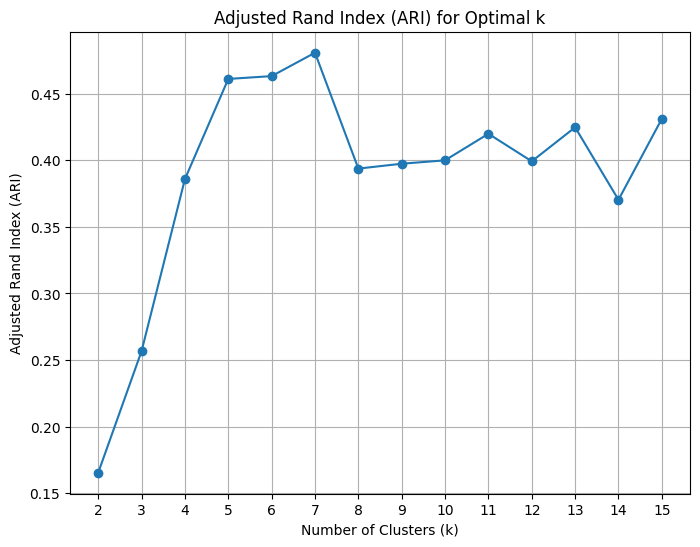

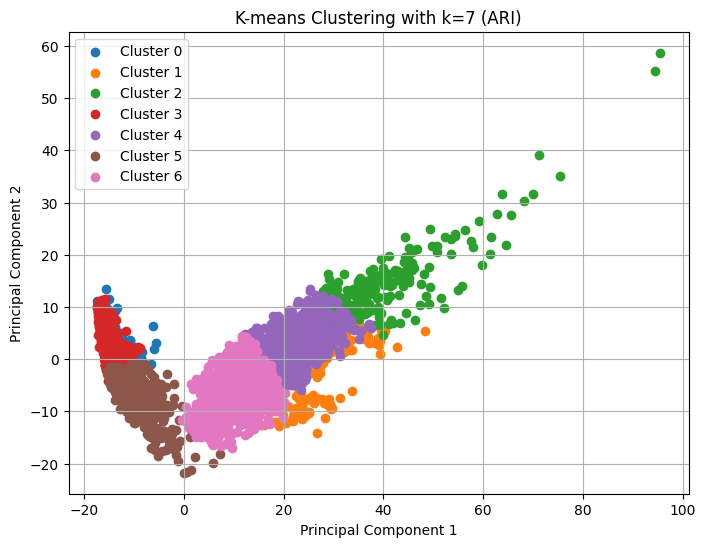

In [ ]:

# Adjusted Rand Index (ARI) for the embeddings
ari_scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings)
    ari = adjusted_rand_score(y_train.squeeze(), clusters)
    ari_scores.append(ari)

# Plotting ARI Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 16), ari_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Adjusted Rand Index (ARI) for Optimal k')
plt.xticks(range(2, 16))
plt.grid(True)
plt.show()

# Choose k based on ARI
ari_k = 7 # Change this based on the plot
kmeans_ari = KMeans(n_clusters=ari_k, random_state=42, n_init=10)
clusters_ari = kmeans_ari.fit_predict(X_train)

# PCA for visualization
pca = PCA(n_components=2)
X_train_pca_ari = pca.fit_transform(X_train)
# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(ari_k):
    plt.scatter(X_train_pca_ari[clusters_ari == i, 0], X_train_pca_ari[clusters_ari == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means Clustering with k={ari_k} (ARI)')
plt.legend()
plt.grid(True)
plt.show()

